## Import

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
import torchvision.models as models
import torchvision.datasets as dt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset

In [2]:
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
from pytorch_msssim import SSIM, MS_SSIM, ms_ssim
from zipfile import ZipFile
import os
from PIL import Image
from pathlib import Path
import glob
from piq import psnr, ssim, LPIPS, MultiScaleSSIMLoss
from tqdm.notebook import tqdm
from kornia.color import rgb_to_lab, bgr_to_rgb, lab_to_rgb
%matplotlib inline

## Random Seed

In [3]:
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Image Dim and Batch Size

In [5]:
img_dim = 256
batch_size = 4

In [6]:
def ab_Norm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab * 128
    return ab.long()

def ab_UnNorm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab / 128
    return ab.float()

def l_Norm(l_x):
    l = torch.clone(l_x)
    l = (l * 100) + 50
    return l.long()

def l_UnNorm(l_x):
    l = torch.clone(l_x)
    l = (l - 50.0) / 100.0
    return l.float()

def fullImg(inp, tar):
    return torch.cat((inp, tar), 0)

def fullImgs(inp, tar):
    return torch.cat((inp, tar), 1)

def getRGB(img):
    x = torch.clone(img)
    x[0] = (x[0] * 100.0) + 50.0
    x[1:] = x[1:] * 128.0
    return (lab_to_rgb(x) * 255.0).long()

def getLABs(ab):
    ab = (ab * 128.0) + 128.0
    return ab

def getRGBs(img):
    x = torch.clone(img)
    x[0:, 0, 0:, 0:] = (x[0:, 0, 0:, 0:] * 100.0) + 50.0
    x[0:, 1:, 0:, 0:] = x[0:, 1:, 0:, 0:] * 128.0
    return lab_to_rgb(x) * 255.0

def getWinSize(x):
    dim = x.shape[-1]
    
    if dim < 165:
        return ((dim / (2**4)) + 1) - 2
    else:
        return 11

## Dataset

In [7]:
trans = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
])

In [8]:
class ColorDT(Dataset):
    def __init__(self, path='', transfrom = None):
        self.data = glob.glob(f'{path}*.jpg')
        self.transform = transfrom
        
    def __getitem__(self, index):
        img = Image.open(self.data[index])
        
        if self.transform is not None:
            img = self.transform(img)
            
        img = np.asarray(img)
        img = torch.clone(torch.from_numpy(img)).permute(2,0,1) / 255
        
        img = rgb_to_lab(img)
        
        input_img = img[0,0:,0:].unsqueeze(0)
        input_img = l_UnNorm(input_img)
        
        target_img = img[1:,0:,0:]
        target_img = ab_UnNorm(target_img)
        
        return {
            'input' : input_img,
            'target' : target_img,
        }
    
    def __len__(self):
        return len(self.data)

In [9]:
# train_img_data = pd.read_csv('train.csv')
# train_img_data = list(train_img_data['img_path'])

# val_img_data = pd.read_csv('val.csv')
# val_img_data = list(val_img_data['img_path'])

# train_path = 'D:\\ColorNet\\Datasets\\Coco\\CocoTrain\\'
# val_path = 'D:\\ColorNet\\Datasets\\Coco\\CocoVal\\'

train_path = 'D:\\ColorNet\\Datasets\\KC\\KCTrain\\'
val_path = 'D:\\ColorNet\\Datasets\\KC\\KCVal\\'

In [10]:
train_set = ColorDT(train_path, trans)
val_set = ColorDT(val_path, trans)

## Sample Image

In [11]:
v = 50
imp = val_set[v]['input']
tar = val_set[v]['target']

In [12]:
imp

tensor([[[-4.7760e-03,  2.8658e-03,  1.0959e-02,  ..., -2.4348e-02,
          -5.3648e-02, -7.5826e-02],
         [ 1.8558e-02,  2.5075e-02,  2.7923e-02,  ..., -2.8147e-02,
          -5.3740e-02, -6.6666e-02],
         [ 5.0489e-03,  1.4409e-02,  2.3784e-02,  ..., -2.6937e-02,
          -5.1236e-02, -6.7756e-02],
         ...,
         [-2.2889e-02,  4.7241e-03,  2.0632e-02,  ...,  9.9038e-02,
           1.6882e-01,  1.8816e-01],
         [-4.9483e-03,  2.2566e-02,  3.3209e-02,  ...,  3.2421e-02,
           1.2976e-01,  1.8139e-01],
         [-1.6258e-04,  2.6144e-02,  3.9526e-02,  ..., -1.0919e-02,
           6.6656e-02,  1.5195e-01]]])

In [13]:
tar

tensor([[[0.0945, 0.0930, 0.0938,  ..., 0.1724, 0.1808, 0.1769],
         [0.0923, 0.0876, 0.0843,  ..., 0.1631, 0.1708, 0.1696],
         [0.0995, 0.0914, 0.0833,  ..., 0.1558, 0.1668, 0.1770],
         ...,
         [0.1015, 0.0876, 0.0751,  ..., 0.1000, 0.0854, 0.0902],
         [0.0941, 0.0805, 0.0769,  ..., 0.0966, 0.0790, 0.0901],
         [0.0959, 0.0787, 0.0714,  ..., 0.0971, 0.0727, 0.0914]],

        [[0.0799, 0.0839, 0.0792,  ..., 0.2951, 0.2963, 0.2955],
         [0.0832, 0.0859, 0.0845,  ..., 0.2827, 0.2834, 0.2792],
         [0.0865, 0.0877, 0.0889,  ..., 0.2794, 0.2814, 0.2827],
         ...,
         [0.2294, 0.2267, 0.2253,  ..., 0.2129, 0.1320, 0.0973],
         [0.2388, 0.2362, 0.2297,  ..., 0.2683, 0.1671, 0.1245],
         [0.2481, 0.2441, 0.2361,  ..., 0.3003, 0.1992, 0.1395]]])

In [14]:
def showLab(img):
    plt.figure(figsize=(50,50), dpi=50)

    plt.subplot(241)
    plt.axis('off')
    plt.title('L', fontdict={'fontsize' : 30})
    plt.imshow(img[0], cmap = plt.cm.gray)

    plt.subplot(242)
    plt.axis('off')
    plt.title('A', fontdict={'fontsize' : 30})
    plt.imshow(img[1], cmap = plt.cm.gray)

    plt.subplot(243)
    plt.axis('off')
    plt.title('B', fontdict={'fontsize' : 30})
    plt.imshow(img[2], cmap = plt.cm.gray)

    plt.subplot(244)
    plt.axis('off')
    plt.title('Target', fontdict={'fontsize' : 30})
    plt.imshow(getRGB(img).permute(1, 2, 0), cmap = plt.cm.gray)

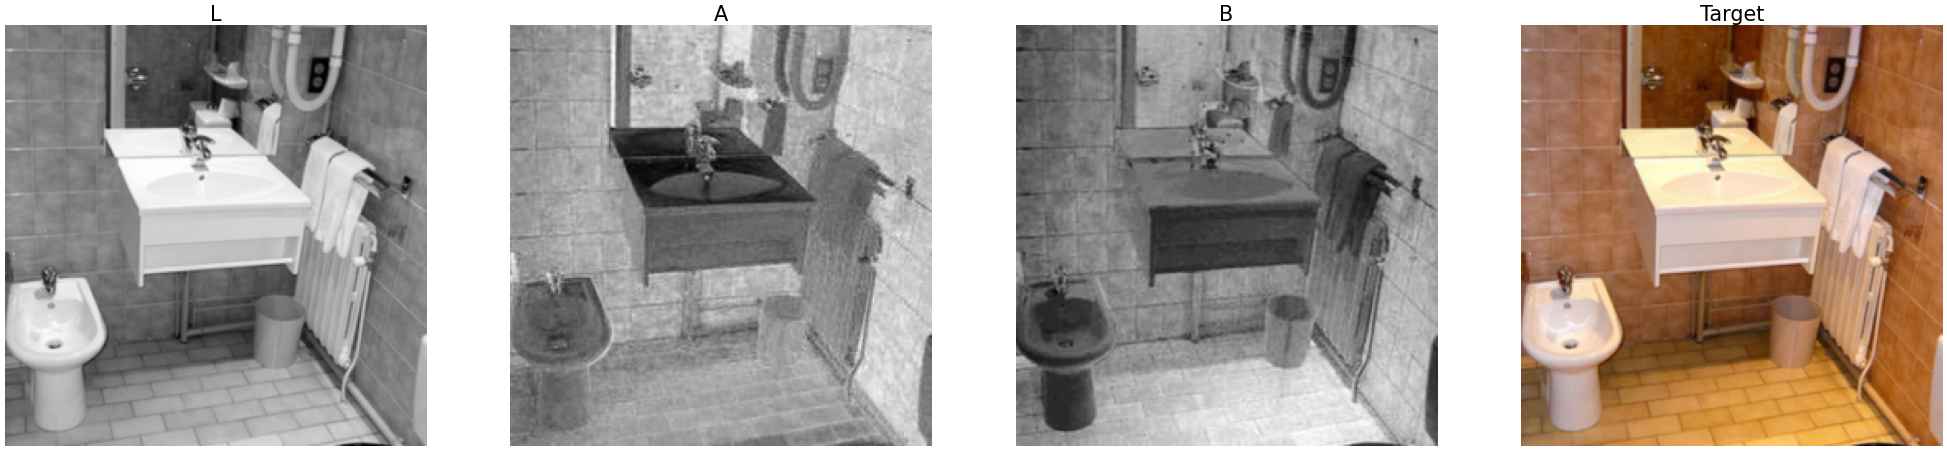

In [15]:
showLab(fullImg(imp, tar))

In [16]:
def showRGB(img):    
    plt.figure(figsize=(50,50), dpi=50)
    
    img = img.cpu().permute(1,2,0)
    img = img.detach().numpy() 
    
    for i in range(3):
        temp = np.zeros(img.shape, dtype='uint8')
        temp[:,:,i] = img[:,:,i]
        
        plt.subplot(int(f'14{i+1}'))
        plt.axis('off')
        plt.imshow(temp)
    
    img = img / 255
    plt.subplot(144)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [17]:
# showRGB(imp)

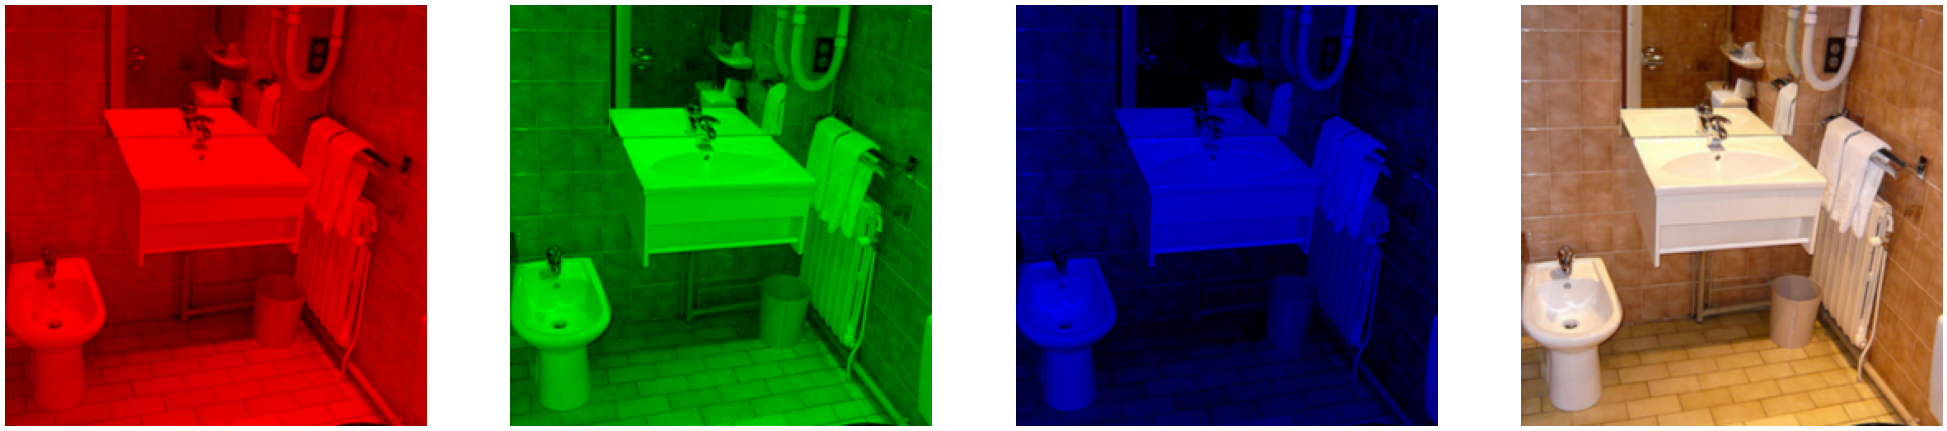

In [18]:
showRGB(getRGB(fullImg(imp, tar)))

## DataLoaders|

In [19]:
train_dl = DataLoader(train_set, batch_size)
val_dl = DataLoader(val_set, batch_size)

## show Result

In [20]:
def pltSubpot(cord, pos, cp, title, pic, titleShow = True):
    plt.subplot2grid(cord, pos, colspan=cp)
    plt.axis('off')
    if titleShow:
        plt.title(title, fontdict = {'fontsize': 20})    
    plt.imshow(pic, cmap = plt.cm.gray)

## Load Model Specification

In [21]:
model_dir = './Saved/'
if Path(model_dir).is_dir():
    model_data_folders = os.listdir(model_dir)

In [22]:
def specFromName(name):
    spec = name.split('_')
    return spec[0], spec[1], spec[2], spec[3], spec[4], spec[5], spec[6]

In [23]:
# def modelInfo(choice = 1, result = None):
#     info = ''
#     if choice == 1:
#         info = f"Architecture\t: {specs['arch']}\nEncoder\t\t: {specs['encoder']}\nLoss in ColorSpace\t: {specs['colorsspace']}\nLoss Function\t: {specs['loss_fn']}\nEmbedding\t: {specs['embedding']}\nEncoder Weights\t: {specs['enc_wei']}"
#         return 
#     elif choice == 2:
#         info = f"Architecture\nEncoder\nLoss in ColorSpace\nLoss Function\nEmbedding\nEncoder Weights"
#         if result != None:
#             for i in result:
#                 info = info+f'\n{i}'
#     else:
#         info = f": {specs['arch']}\n: {specs['encoder']}\n: {specs['colorsspace']}\n: {specs['loss_fn']}\n: {specs['embedding']}\n: {specs['enc_wei']}"
#         if result != None:
#             for i in result:
#                 info = info+f'\n: {i}'
    
#     return info

In [24]:
specs = {}

if Path(model_dir).is_dir() and len(model_data_folders) > 0:
    print('Choose a Model >>\n')
    for i, md in enumerate(model_data_folders):
        print(f'{(i+1):2d}. {md}')
    
    print(f'{(len(model_data_folders)+1):2d}. Add New Model')

    user_choice = True
    if user_choice:
        md_in = int(input('Choice: '))
    else:
        md_in = int(5)
    
    if md_in < len(model_data_folders)+1:
        model_data = model_data_folders[md_in-1]
        arch, encoder1, encoder2, colorsspace, loss_fn, embedding, enc_wei = specFromName(model_data)
    else:
        print('Add a Model >>\n')
        arch = str(input('Architecture: ')).capitalize()
        encoder1 = str(input('Encoder 1: ')).capitalize()
        encoder2 = str(input('Encoder 2: ')).capitalize()
        colorsspace = str(input('Color Space: ')).upper()
        loss_fn = str(input('Loss Function: ')).upper()
        embedding = str(input('Embedding: ')).capitalize()
        enc_wei = str(input('Encoder Weights: ')).capitalize()

    specs = {'arch' : arch,
             'encoder1' : encoder1,
             'encoder2' : encoder2,
             'colorsspace' : colorsspace,
             'loss_fn' : loss_fn,
             'embedding' : embedding,
             'enc_wei' : enc_wei,
            }
else:
    print('Add a Model >>\n')
    specs['arch'] = str(input('Architecture: ')).capitalize()
    specs['encoder1'] = str(input('Encoder 1: ')).capitalize()
    specs['encoder2'] = str(input('Encoder 2: ')).capitalize()
    specs['colorsspace'] = str(input('Color Space: ')).upper()
    specs['loss_fn'] = str(input('Loss Function: ')).upper()
    specs['embedding'] = str(input('Embedding: ')).capitalize()
    specs['enc_wei'] = str(input('Encoder Weights: ')).capitalize()

print(specs)

Choose a Model >>

 1. Unet++_Resnet152_None_LAB_MS-SSIM_None_Imagenet
 2. Unet++_Resnet152_None_RGB_MS-SSIM_None_Imagenet
 3. Unet++_Resnet34_None_BOTH_MS-SSIM_None_Imagenet
 4. Add New Model
Choice: 4
Add a Model >>

Architecture: unet++
Encoder 1: resnet50
Encoder 2: none
Color Space: lab
Loss Function: ms-ssim
Embedding: none
Encoder Weights: imagenet
{'arch': 'Unet++', 'encoder1': 'Resnet50', 'encoder2': 'None', 'colorsspace': 'LAB', 'loss_fn': 'MS-SSIM', 'embedding': 'None', 'enc_wei': 'Imagenet'}


## Save and Load Model Data

In [25]:
# Loading previous losses and accuracies
def loadModelData(directory='./Saved/'):
    acc = []
    los = []
    if not Path('./Saved').is_dir():
        Path.mkdir(Path('./Saved'))
        
    if Path(directory).is_dir():
        if os.path.exists(f'{directory}/modelParams.pth'):
            model.load_state_dict(torch.load(f'{directory}/modelParams.pth'))
    else:
        Path.mkdir(Path(directory))
        
    try:
        result_df = pd.read_csv(f'{directory}/Val_Result.csv')
        result_dict = result_df.to_dict()
        acc = list(result_dict['accuracy'].values())
        los = list(result_dict['loss'].values())
    
    except IOError:
        print('file not Found')
    
    return acc, los

In [26]:
# save the model parameters to the disk
def saveModelData(directory='./Saved/', testScore = None, test_file = 'testScore'):
    torch.save(model.state_dict(), f'{directory}/modelParams.pth')
    
    if testScore != None:
        with open(f'{directory}/{test_file}.txt', 'w') as fd:
                fd.writelines(f"{i}\n" for i in testScore)
    
    result_dict = {
        'loss': val_losses,
        'accuracy' : val_accuracies,
    }
    
    result_df = pd.DataFrame(result_dict)
    
    result_df.to_csv(f'{directory}/Val_Result.csv', index = False)

## Our Model

In [27]:
class ColorNet(nn.Module):
    def __init__(self, specs = {}, device = torch.device('cuda')):
        super(ColorNet, self).__init__()
        self.specs = specs
        self.device = device
        
        if 'net++' in self.specs['arch'].lower():
            self.net1 = smp.UnetPlusPlus(
                encoder_name = self.specs['encoder1'].lower(),
                encoder_weights = self.specs['enc_wei'].lower(),
                in_channels = 1,
                classes = 2,
                activation = None,
            )
            
            if specs['encoder2'].lower() != 'none':
                self.net2 = smp.UnetPlusPlus(
                    encoder_name = self.specs['encoder2'].lower(),
                    # encoder_depth = 3,
                    encoder_weights = self.specs['enc_wei'].lower(),
                    # decoder_channels = [256, 128, 64],
                    in_channels = 3,
                    classes = 3,
                    activation = None,
                )
        else:
            self.net1 = smp.Unet(
                encoder_name = self.specs['encoder1'].lower(),
                encoder_weights = self.specs['enc_wei'].lower(),
                in_channels = 1,
                classes = 2,
                activation = None,
            )
            
            if specs['encoder2'].lower() != 'none':
                self.net2 = smp.Unet(
                    encoder_name = self.specs['encoder2'].lower(),
                    # encoder_depth = 3,
                    encoder_weights = self.specs['enc_wei'].lower(),
                    # decoder_channels = [256, 128, 64],
                    in_channels = 3,
                    classes = 3,
                    activation = None,
                )
            
        
        # self.net = nn.Sequential(      
        #     self.net1,
        #     self.net2,
        # )
        
        self.net1 = self.net1.to(self.device)
        
        if specs['encoder2'].lower() != 'none':
            self.net2 = self.net2.to(self.device)
        
        self.tan = nn.Sequential(      
            nn.Tanh(),
        )
        
    def forward(self, x):
        self.train()
        
        out = self.net1(x)
        
        out = self.tan(out)
        
        out = torch.cat((x, out), 1)
        
        if specs['encoder2'].lower() != 'none':
            out = self.net2(out)
            out = self.tan(out)
        
        return out
    
    def predict(self, x):
        self.eval()
        
        out = self.net1(x)
        
        out = self.tan(out)
        
        out = torch.cat((x, out), 1)
        
        if specs['encoder2'].lower() != 'none':
            out = self.net2(out)
            out = self.tan(out)
        
        return out

## Loss Func

In [28]:
class ColorLoss(nn.Module):
    def __init__(self, specs, alpha = 0.8, beta = 0.6, device = torch.device('cuda')):
        super(ColorLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.specs = specs
        
        self.alpha = alpha
        self.beta = beta
        
        if self.specs['embedding'].lower() == 'resnet18':
            self.embnet = models.resnet18(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet34':
            self.embnet = models.resnet34(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet50':
            self.embnet = models.resnet50(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet101':
            self.embnet = models.resnet101(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet152':
            self.embnet = models.resnet152(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'vgg16':
            self.embnet = models.vgg16(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'vgg19':
            self.embnet = models.vgg19(pretrained = True, progress=True)
        else:
            self.embnet = None
        
        if self.embnet != None:
            for param in self.embnet.parameters():
                param.requires_grad = False
            
            self.embnet = self.embnet.to(device)
        
    def forward(self, preds, targs):
        loss = self.__getLoss(preds, targs)
        return loss
    
    def __getLoss(self, preds, targs):
        loss = 0
        lossfn = self.specs['loss_fn'].lower()
        
        if self.specs['colorsspace'].lower() == 'rgb':
            preds = self.__getRGBs(preds)
            targs = self.__getRGBs(targs)
        elif self.specs['colorsspace'].lower() == 'lab':
            preds = preds[0:, 1:, 0:, 0:]
            targs = targs[0:, 1:, 0:, 0:]
            
            preds = ((preds + 1) / 2) * 255.0
            targs = ((targs + 1) / 2) * 255.0
        else:
            predLab = preds[0:, 1:, 0:, 0:]
            targLab = targs[0:, 1:, 0:, 0:]
            predLab = ((preds + 1) / 2) * 255.0
            targLab = ((targs + 1) / 2) * 255.0
            
            predRgb = self.__getRGBs(preds)
            targRgb = self.__getRGBs(targs)
        
        #Loss Calculation
        if self.specs['colorsspace'].lower() == 'both':
            lab_ms = 1 - self.__msSsimLoss(predLab, targLab)
            rgb_ms = 1 - self.__msSsimLoss(predRgb, targRgb)
            
            loss = ((lab_ms * 0.5) + (rgb_ms * 0.5))
        else:
            if 'fm-ssim' in lossfn:
                loss = self.__featureMapSSIMLoss(preds, targs)

            elif lossfn == 'ms-ssim':
                loss = 1 - self.__msSsimLoss(preds, targs)

            elif lossfn == 'ssim':
                loss = 1 - self.__ssimLoss(preds, targs)

            else:
                if self.embnet == None:
                    loss = self.mse(preds, targs)
                else:
                    embednet = nn.Sequential(*list(self.embnet.children())[:-2])
                    loss = self.mse(embednet(preds), embednet(targs))
        
        return loss
    
    def __getRGBs(self, img):
        x = torch.clone(img)
        x[0:, 0, 0:, 0:] = (x[0:, 0, 0:, 0:] * 100.0) + 50.0
        x[0:, 1:, 0:, 0:] = x[0:, 1:, 0:, 0:] * 128.0
        
        return lab_to_rgb(x) * 255.0

    def __getWinSize(self, x):
        dim = x.shape[-1]

        if dim < 165:
            return ((dim / (2**4)) + 1) - 2
        else:
            return 11
        
    def __msSsimLoss(self, preds, targs):
        win = self.__getWinSize(preds)
            
        return ms_ssim(preds, targs, data_range = 256.0, size_average = True, win_size = win)
    
    def __ssimLoss(self, preds, targs):
        return ssim(preds, targs)
        
    def __featureMapSSIMLoss(self, preds, targs):
        predRGBs = getRGBs(preds)
        targRGBs = getRGBs(targs)
        
        fmloss = 1 - self.__featureMapLoss(predRGBs, targRGBs)
        msloss = 1 - self.__msSsimLoss(predRGBs, targRGBs)

        loss = ((self.alpha * msloss) + (self.beta * fmloss)) / (self.alpha + self.beta)
        return loss
    
    def __featureMapLoss(self, preds, targs):
        # resnet embedding
        lossfn = self.specs['loss_fn'].lower()        
        
        #feature map with dimension 16x16
        if 's5' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-3])
            winSize = 1
            
        #feature map with dimension 32x32
        elif 's4' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-4])
            winSize = ((32 / (2**4)) + 1) - 2
            
        #feature map with dimension 64x64
        elif 's3' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-5])
            winSize = ((64 / (2**4)) + 1) - 2
        
        #feature map with dimension 128x128
        elif 's2' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-7])
            winSize = ((128 / (2**4)) + 1) - 2

        #feature map with dimension >= 256x256
        else:
            embednet = nn.Sequential(*list(self.embnet.children())[:-7])
            winSize = 11
        
        preds = embednet(preds)
        targs = embednet(targs)
        FMLoss = ms_ssim(preds, targs, data_range=1, size_average=True, win_size = winSize)
        
        return FMLoss

In [29]:
# class ColorLoss(nn.Module):
#     def __init__(self, specs, alpha = 0.8, beta = 0.6, device = torch.device('cuda')):
#         super(ColorLoss, self).__init__()
#         self.mse = nn.MSELoss()
#         self.specs = specs
        
#         self.alpha = alpha
#         self.beta = beta
        
#         if self.specs['embedding'].lower() == 'resnet18':
#             self.embnet = models.resnet18(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'resnet34':
#             self.embnet = models.resnet34(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'resnet50':
#             self.embnet = models.resnet50(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'resnet101':
#             self.embnet = models.resnet101(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'resnet152':
#             self.embnet = models.resnet152(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'vgg16':
#             self.embnet = models.vgg16(pretrained = True, progress=True).cuda()
#         elif self.specs['embedding'].lower() == 'vgg19':
#             self.embnet = models.vgg19(pretrained = True, progress=True).cuda()
#         else:
#             self.embnet = None
        
#         if self.embnet != None:
#             for param in self.embnet.parameters():
#                 param.requires_grad = False
            
#             self.embnet = self.embnet.to(device)

#     def forward(self, imps, preds, targs):
#         loss = self.__getLoss(imps, preds, targs)
#         return loss
    
#     def __getLoss(self, imps, pred, targ):
#         loss = 0
#         lossfn = self.specs['loss_fn'].lower() 

#         if self.specs['colorsspace'].lower() == 'lab':
#             preds = ((pred * 128.0) + 128.0).float()
#             targs = ((targ * 128.0) + 128.0).float()
# #             print('lab')
#         else:
#             preds = torch.cat((imps, pred), 1)
#             targs = torch.cat((imps, targ), 1)
#             preds = getRGBs(preds)
#             targs = getRGBs(targs)
# #             print('rgb')
            
#         #Loss Calculation
#         if 'fm-ssim' in lossfn:
#             loss = self.__featureMapSSIMLoss(imps, pred, targ)
# #             print('fmid')
            
#         elif lossfn == 'ms-ssim':
#             loss = 1 - self.__msSsimLoss(preds, targs)
# #             print('ms-ssim')

#         elif lossfn == 'ssim':
#             loss = 1 - self.__ssimLoss(preds, targs)
        
#         elif lossfn == 'xm-ssim':
#             predLAB = ((pred * 128.0) + 128.0).float() / 255.0
#             targLAB = ((targ * 128.0) + 128.0).float() / 255.0
            
#             predRGB = torch.cat((imps, pred), 1)
#             targRGB = torch.cat((imps, targ), 1)
#             predRGB = getRGBs(predRGB)
#             targRGB = getRGBs(targRGB)
            
#             ssimLoss = 1 - self.__ssimLoss(predLAB, targLAB)
#             msSsimLoss = 1 - self.__msSsimLoss(predRGB, targRGB)
            
#             loss = ((self.alpha * msSsimLoss) + (self.beta * ssimLoss)) / (self.alpha + self.beta)
            
#         elif lossfn == 'mse':
#             if self.embnet == None:
#                 loss = self.mse(torch.sigmoid(preds), torch.sigmoid(targs))
# #                 print('mse, not-embeded')
#             else:
#                 if self.specs['colorsspace'].lower() == 'lab':
#                     preds = torch.cat((imps, pred), 1)
#                     targs = torch.cat((imps, targ), 1)
#                 embednet = nn.Sequential(*list(self.embnet.children())[:-2])
#                 loss = self.mse(torch.sigmoid(embednet(preds)), torch.sigmoid(embednet(targs)))
# #                 print('mse, embeded')
                
#         elif lossfn == 'mse-ssim':        
#             msLoss = 1 - self.__msSsimLoss(preds, targs)
#             mseLoss = 0
#             if self.embnet == None:
#                 mseLoss = self.mse(torch.sigmoid(preds), torch.sigmoid(targs))
# #                 print('mse+ms-ssim, not-embeded')
#             else:
#                 if self.specs['colorsspace'].lower() == 'lab':
#                     preds = torch.cat((imps, pred), 1)
#                     targs = torch.cat((imps, targ), 1)
#                 embednet = nn.Sequential(*list(self.embnet.children())[:-2])
#                 mseLoss = self.mse(torch.sigmoid(embednet(preds)), torch.sigmoid(embednet(targs)))
# #                 print('mse+ms-ssim, embeded')

#             loss = ((self.alpha * msLoss) + (self.beta * mseLoss)) / (self.alpha + self.beta)
            
#         else:
#             loss = 1 - self.__msSsimLoss(preds, targs)
# #             print('else')

#         return loss
    
#     def __msSsimLoss(self, preds, targs):
#         return ms_ssim(preds, targs, data_range=255.0, size_average=True)
    
#     def __ssimLoss(self, preds, targs):
#         return ssim(preds/255.0, targs/255.0)
        
#     def __featureMapSSIMLoss(self, imps, pred, targ):
#         preds = torch.cat((imps, pred), 1)
#         targs = torch.cat((imps, targ), 1)
#         predRGBs = getRGBs(preds)
#         targRGBs = getRGBs(targs)
        
#         fmloss = 1 - self.__featureMapLoss(predRGBs, targRGBs)
#         msloss = 1 - self.__msSsimLoss(predRGBs, targRGBs)

#         loss = ((self.alpha * msloss) + (self.beta * fmloss)) / (self.alpha + self.beta)
#         return loss
    
#     def __featureMapLoss(self, preds, targs):
#         # resnet embedding
#         lossfn = self.specs['loss_fn'].lower()        
        
#         #feature map with dimension 16x16
#         if 's5' in lossfn:
#             embednet = nn.Sequential(*list(self.embnet.children())[:-3])
#             winSize = 1
            
#         #feature map with dimension 32x32
#         elif 's4' in lossfn:
#             embednet = nn.Sequential(*list(self.embnet.children())[:-4])
#             winSize = ((32 / (2**4)) + 1) - 2
            
#         #feature map with dimension 64x64
#         elif 's3' in lossfn:
#             embednet = nn.Sequential(*list(self.embnet.children())[:-5])
#             winSize = ((64 / (2**4)) + 1) - 2
        
#         #feature map with dimension 128x128
#         elif 's2' in lossfn:
#             embednet = nn.Sequential(*list(self.embnet.children())[:-7])
#             winSize = ((128 / (2**4)) + 1) - 2

#         #feature map with dimension >= 256x256
#         else:
#             embednet = nn.Sequential(*list(self.embnet.children())[:-7])
#             winSize = 11
        
#         preds = embednet(preds)
#         targs = embednet(targs)
#         FMLoss = ms_ssim(preds, targs, data_range=1, size_average=True, win_size = winSize)
        
#         return FMLoss

## Model Intialization

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Model_Arc-Encoder-ColorSpace-Loss-Embedding.pth'
model_save_file = "_".join([specs[x] for x in specs])
model_dir_name = f'./Saved/{model_save_file}'

# Model
model = ColorNet(specs = specs, device = device).to(device)

val_accuracies, val_losses = loadModelData(directory=model_dir_name)

# hyper param
alpha = 0.8
beta = 0.6

# loss
lossFn = ColorLoss(specs, alpha, beta).to(device)
# lossFn = MultiScaleSSIMLoss()

# accFn = MS_SSIM(data_range=255, size_average=True, channel=3).to(device)

accAllFn = {
    'psnr' : psnr,
    'ssim' : ssim,
    'lpips' : LPIPS().to(device),
}

learning_rate = 1e-04
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, eps=1e-05)

file not Found


C:\ProgramData\Anaconda3\lib\site-packages\piq\perceptual.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = [torch.tensor(w) for w in weights]


In [32]:
# summary(model, (3, 256, 256), device="cuda")

## Training

In [33]:
# loss of a batch    
def train(model, inputs, targets, optimizer=None, lossFn = None, metricFn = None, device = 'cuda'):
    model.train()
    
    # calculate the loss
    inputs = inputs.to(device)
    targets = targets.to(device)
    predictions = model(inputs)   
    
    # print(predictions.shape)
    # print(targets.shape)
    
    targets = torch.cat((inputs, targets), 1)
    
    predRGB = getRGBs(predictions)
    targRGB = getRGBs(targets)
    
    # Accuracy Calculation
    accuracy = {}
    if metricFn is not None:
        # compute the metric
        for mt in metricFn:
            accuracy[mt] = metricFn[mt](predRGB / 255.0, targRGB / 255.0).item()
            
    # Loss Calculation
#     print(predictions, targets)
    loss = lossFn(predictions, targets)
    
    
    # Back Propagation
    if optimizer is not None:
        # compute gradients
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # reset the gradients
        optimizer.zero_grad()
        
    # return loss.item(), len(inputs), accuracy.item()
    
    return loss.item(), len(inputs), accuracy

In [34]:
# evaluation function
def evaluate(model, val_dl, lossFn = None, metricFn = None, device = 'cuda'):
    model.eval()
    with torch.no_grad():
        # pass each batch throgh the model
        print('Validation Loop >>>>')
        results = []
        val_losses = 0
        val_accs = 0
        count = 0
        
        pbar = tqdm(val_dl)
        for batch in pbar:
            count = count + 1
            
            val_loss, val_total, val_metric = train(model, batch['input'], batch['target'], lossFn = lossFn, metricFn = metricFn, device = device)
            results.append((val_loss, val_total, val_metric))
            
            val_losses = val_losses + val_loss
            val_accs = val_accs + val_metric['ssim']
            
            avg_val_loss = val_losses / count
            avg_val_acc = val_accs / count
            
            pbar.set_description(f"Loss : {avg_val_loss:.6f} | Accuracy : {avg_val_acc:.6f} | % ")            
                 
        
        # seperate losses, counts and matrices
        losses, nums, metrices = zip(*results)
        
        # total size of the dataset
        total = np.sum(nums)
        
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = {}
        
        if metricFn is not None:
            # Avg. metric accross batches
#             avg_metric = np.sum(np.multiply(metrices, nums)) / total
            acc = {}
            for mt in metricFn:
                acc = [a[mt] for a in metrices]
                avg_metric[mt] = np.sum(np.multiply(acc, nums)) / total
            

    return avg_loss, total, avg_metric

In [35]:
def fit(epochs, model, optimizer, train_dl, val_dl, lossFn = None, metricFn=None, device = 'cuda', sk = None):
    
    for epoch in tqdm(range(epochs)):
        
        if sk is not None:
            Train_All_Data = pd.read_csv('train_sep.csv')
            Train_Data = list(Train_All_Data.loc[Train_All_Data['idx'] == sk+epoch+1]['img_path'])

            TrainSet = ColorDataset(Train_Data, transform)

            train_dl = DataLoader(TrainSet,
                                  batch_size)
        
        # training
        print('Training Loop >>>>')
        train_losses = 0
        train_accs = 0
        count = 0
        
        pbar = tqdm(train_dl)
        for batch in pbar:
            count = count+1
            
            train_loss, train_total, train_metric = train(model, batch['input'], batch['target'], optimizer, lossFn = lossFn, metricFn = metricFn, device = device)
            
            train_losses = train_losses + train_loss
            train_accs = train_accs + train_metric['ssim']
            
            avg_train_loss = train_losses / count
            avg_train_acc = train_accs / count
            
            pbar.set_description(f"Loss : {avg_train_loss:.6f} | Accuracy : {avg_train_acc:.6f} | % ")
            
        #evaluation
        result = evaluate(model, val_dl, lossFn = lossFn, metricFn = metricFn, device = device)
        val_loss, val_total, val_metric = result
        
        # scheduler.step(val_loss)
        
        val_accuracies.append(val_metric['ssim'])
        val_losses.append(val_loss)
        
        # print progress
        if metricFn is None:
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.5f}")
        else:            
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.5f}, Accuracy : {val_metric['ssim']:.8f}")
        
        saveModelData(directory=model_dir_name)

## Fitting

Test Image Target >>>
Test Image Output >>>


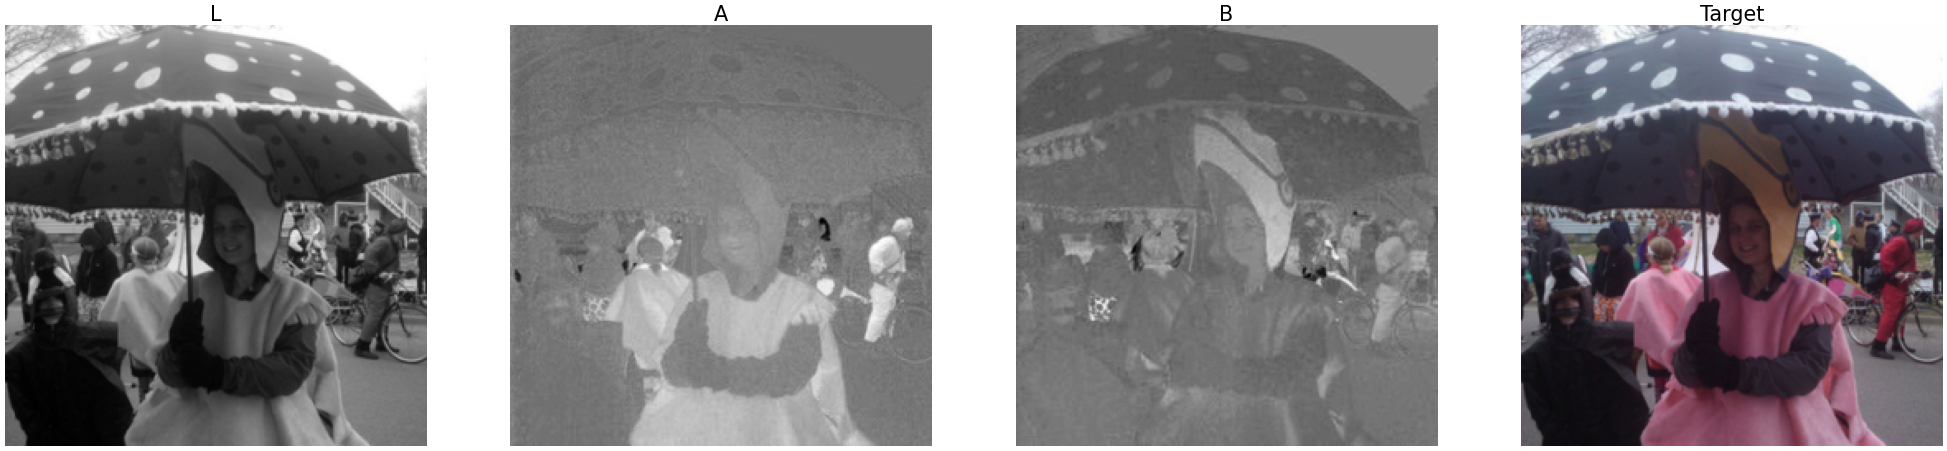

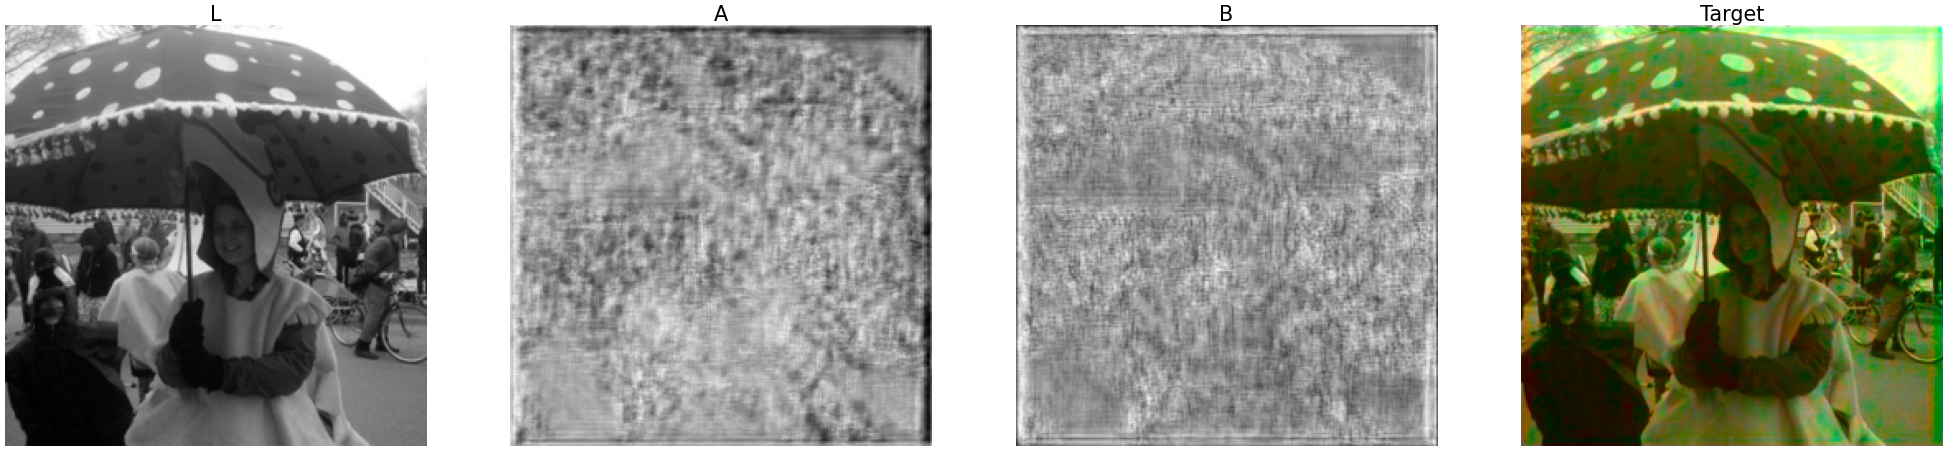

In [36]:
v_img = val_set[8]
x = model.predict(v_img['input'].unsqueeze(0).to(device)).cpu()

print('Test Image Target >>>')
target = fullImg(v_img['input'], v_img['target'])
showLab(target)

print('Test Image Output >>>')
prediction = x.squeeze(0).detach()
showLab(prediction)

# print(target)
# print(prediction)

In [37]:
def fitLoop(epoch = 10, lr = 1e-4, skip = False, sk = None):
    if not skip:
        optimizer.param_groups[0]['lr'] = lr
        fit(epoch, model, optimizer, train_dl, val_dl, lossFn = lossFn, metricFn = accAllFn, device = device, sk = sk)
        saveModelData(directory=model_dir_name)
#         testResult(ColorNet(model, True, True, specs = specs, device = device), 27, f'{model_dir_name}/Results', device = device)

In [38]:
# fitLoop(epoch = 1, lr = 1e-3)

In [39]:
fitLoop(epoch = 4, lr = 1e-3)

Training Loop >>>>



Validation Loop >>>>



Epoch : [1/4], Loss : 0.22741, Accuracy : 0.91577756
Training Loop >>>>



Validation Loop >>>>



Epoch : [2/4], Loss : 0.22798, Accuracy : 0.91643922
Training Loop >>>>



Validation Loop >>>>



Epoch : [3/4], Loss : 0.22237, Accuracy : 0.91670988
Training Loop >>>>



Validation Loop >>>>



Epoch : [4/4], Loss : 0.22203, Accuracy : 0.91565106



In [40]:
saveModelData(directory=model_dir_name)

## Modern and Lagecy Grayscale

In [41]:
# def saveResult(Lagecy = True):
#     saveDir = f'{model_dir_name}/Results3'
#     if not Path(saveDir).is_dir():
#         Path.mkdir(Path(saveDir))

#     if Lagecy:
#         imgDir = './LagecyTest/'
#         f = 'LagecyImg-'
#     else:
#         imgDir = './ModernTest/'
#         f = 'ModernImg-'
#     imgs = os.listdir(imgDir)
    
#     imgList = []
#     for i in imgs:
#         img = Image.open(f'{imgDir}{i}')
#         img = np.asarray(img)
#         img = torch.from_numpy(img).permute(2, 0, 1)
        
#         grayImg = grayTrans(img)
        
#         imgList.append(grayImg / 255.0)
    
#     imgList = torch.stack(tuple(imgList))
    
#     for i, ik in enumerate(imgList):        
#         x = model.predict(ik.unsqueeze(0).to(device))
#         ik = x.squeeze().cpu().permute(1,2,0)
#         ik = (ik * 255)
#         ik = ik.detach().numpy()
#         ik = ik / 255
    
#         fig = plt.figure(figsize=(512, 512), dpi=1, frameon=False)
#         graph_dim = (1, 1)
        
#         pltSubpot(graph_dim, (0, 0), 1, '', ik, titleShow=False)
#         plt.tight_layout(pad=0.0, h_pad=0.0)
        
#         plt.savefig(f'{saveDir}/{f}{i+1}.jpg', bbox_inches='tight', pad_inches=0)
#         plt.close()

In [42]:
# saveResult(True)
# saveResult(False)

In [43]:
# testSets = {
#     'Div2k' : "D:/ColorNet/Datasets/Div2k/",
#     'CocoStaff' : 'D:/ColorNet/Datasets/cocostuff-10k/',
#     'Imagenet10k' : "D:/ColorNet/Datasets/ImagenetCTest10k/",
#     'Places365' : "D:/ColorNet/Datasets/Places365/",
# }

In [44]:
# resizeTrans = transforms.Compose([
#     transforms.Resize((img,512))
# ])

# for test_path in testSets:
#     tset = testSets[test_path]
#     test_img_data = [f'{tset}{img}' for img in os.listdir(tset)]
#     testSet = ColorDT(test_img_data, resizeTrans)
#     test_dl = DataLoader(testSet,
#                          batch_size)
    
#     # TEST
#     test_loss = 0
#     test_acc = {}
    
#     print(f'{test_path} >>>')
    
#     test_loss, total, test_acc = evaluate(model, test_dl, lossFn = lossFn, metricFn = accAllFn, device = device)
#     print(f"Loss : {test_loss:.4f}, Accuracy : {test_acc['ssim']:.4f}")

#     with open(f'{model_dir_name}/TestACC_{test_path}.txt', 'w') as fd:
#         fd.writelines(f"{acc} : {test_acc[acc]:.10f}\n" for acc in test_acc)
        
    
#     print(test_acc)
    
#     saveModelData(directory=model_dir_name, testScore = [test_loss, test_acc['ssim']], test_file = f'{test_path}_acc')

In [45]:
result_df = pd.read_csv(f'{model_dir_name}/Val_Result.csv')

<Figure size 432x288 with 0 Axes>

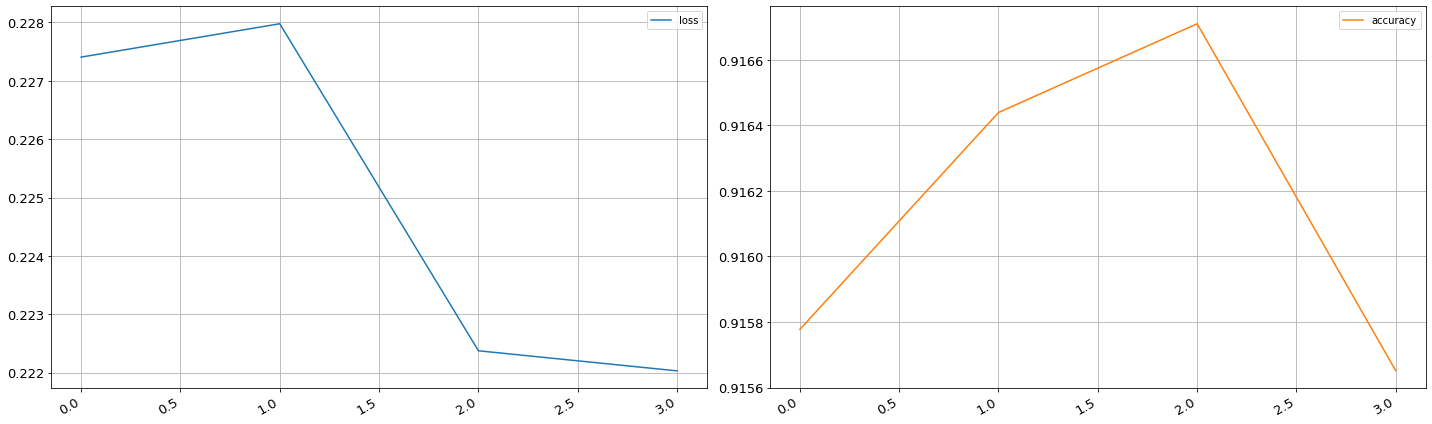

In [46]:
fig = plt.figure()
acc_figs = result_df.plot(figsize=(20, 6), subplots=True, layout=(1,2), fontsize=13, grid=True, legend=True)

# [ax.set_title(name_dict[model_data_folders[i]], fontdict={'fontsize':fontSize}) for i, ax in enumerate(plt.gcf().axes) if i < len(model_data_folders)]
# [ax.set_ylabel('Validation Accuracy', fontdict={'fontsize':fontSize}) for j, ax in enumerate(plt.gcf().axes)]
# [ax.set_xlabel('Training Epoch', fontdict={'fontsize':fontSize}) for j, ax in enumerate(plt.gcf().axes)]

plt.tight_layout()
# plt.savefig(f'{graph_path}/Accuracy_Plot_All.jpg')